# Quantum Fourier Transform multiplier

In this Notebook we build a quantum circuit to multiply two non-negative integers implementing the Quantum Fourier Transform (QFT) multiplier described in section 7 of 
[Quantum Arithmetic with the Quantum Fourier Transform](https://arxiv.org/pdf/1411.5949.pdf).

Let $a$ and $b$ be two non-negative integers, with binary representations:

$|a> = |a_1>\otimes |a_2>\otimes ... \otimes|a_n>$ 

$|b> = |b_1>\otimes |b_2>\otimes ... \otimes|b_n>$.

The algorithm proposed by Ruiz-Perez and Garcia-Escartin to multiply $a$ and $b$ can be subdivided in 4 steps:

* 1\. Build a circuit with $4n$ qubits, where
   *  qubits of indexes $0,...,2n-1$ start as zeroes and will contain the product of $a$ and $b$ at the end of the algorithm,
   *  $a$ is stored in qubits of indexes $2n,2n+1,...,3n-1$,
   *  $b$ is stored in qubits of indexes $3n,3n+1,...,4n-1$.
* 2\. Calculate the QFT of the first $2n$ qubits of the circuit, i.e. the QFT of $0$.
* 3\. Since $ab=b_n 2^0 a + b_{n-1} 2^1 a +...+ b_1 2^{n-1} a,$ the product $ab$ can be obtained by adding $b_n 2^0 a$ to $0$, then adding $ b_{n-1} 2^1 a$, and so on till $ b_1 2^{n-1} a$. All these additions are implemented using rotation gates:
    * 3.1\. If $b_n=1$, perform a series of rotation gates on the first $2n$ qubits, controlled by the qubits of $|a>$, to modify the QFT of $0$ into the QFT of $0+b_n 2^0 a$.
    * 3.2\. If $b_{n-1}=1$, perform a series of rotation gates on the first $2n$ qubits, controlled by the qubits of $|a>$, to modify the QFT of $0+b_n 2^0 a$ into the QFT of $b_n 2^0 a + b_{n-1} 2^1 a$.
    *  ...
    * 3.n\. If $b_{1}=1$, perform a series of rotation gates on the first $2n$ qubits, controlled by the qubits of $|a>$, to modify the QFT of $0+b_n 2^0 a+ b_{n-1} 2^1 a +...+ b_2 2^{n-2} a$ into the QFT of $0+b_n 2^0 a + b_{n-1} 2^1 a +...+ b_1 2^{n-1} a$, i.e. the QFT of $ab$.
* 4\. Finally, apply the inverse of the QFT to the first $2n$ qubits to get the product $ab$.

The figure below shows the four steps of the QFT multiplier:

|<img src="Images/Diagram_circuit.JPG" width="800"/> |
|:--:|
| Figure 1: QFT multiplier as a concatenation of controlled weighted sum blocks|

## The Quantum Fourier Transform

The QFT and its inverse are key components of the QFT multiplier. The function `qft`, which performs the QFT and the function `inverse_qft`, which performs its inverse are imported from the file `qft.py`. 

In [1]:
from qiskit import(QuantumCircuit, execute, Aer)
from qiskit.visualization import plot_histogram
from numpy import pi
from qft import(qft, inverse_qft)

The function `qft` takes a circuit and a number $n$, and performs the QFT on the first $n$ qubits of the circuit. Note that the output of `qft` gives the QFT in reverse order. Of course, one could add a series of swap gates at the end of the circuit to obtain the QFT in the correct order; we decided not to do so, in order to reduce the number of gates used. The fact that `qft` outputs the QFT in reverse order is then taken into account when performing the rotation gates in step 3 of the algorithm.

Below is a simple example of application of `qft` on a circuit with 4 qubits:

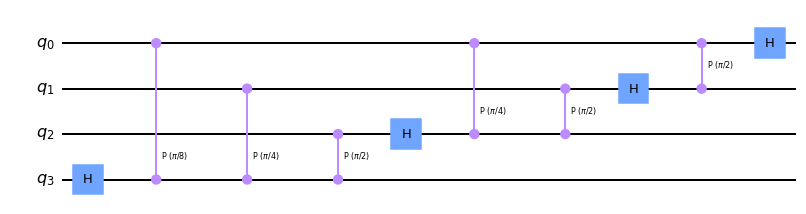

In [2]:
circuit = QuantumCircuit(4) 
circuit = qft(circuit,4)
circuit.draw(output='mpl')

Similarly, the function `inverse_qft` takes a circuit and a number $n$ and performs the inverse QFT on the first $n$ qubits of the circuit.

## The `qft_multiplier` function 

In this section we define our main function, `qft_multiplier`, which takes two non-negative integers and prints out their product. Internally the function performs the following steps:
- it gets the binary representations of $a$ and $b$, ensuring that the two representations have the same length n_bit (adding zeroes to the representation of the shorter number, if needed);
- it creates a circuit with 4n_bit qubits, encoding $a$ in qubits of indexes 2n_bit, 2n_bit +1,...,3n_bit-1, and $b$ in qubits of indexes 3n_bit, 3n_bit+1,...,4n_bit-1;
- it applies `qft` to the first 2n_bit  qubits of the circuit;
- it performs all necessary rotation gates on the first 2n_bit qubits to modify them into the QFT of $ab$;
- it applies `inverse_qft` to the first 2n_bit  qubits;
- it measures the first 2n_bit qubits;
- it runs the circuit on the `qasm_simulator` and returns the result in decimal form.

In [3]:
def qft_multiplier(a, b):
    n_bit = max(a.bit_length(), b.bit_length())
    binary_format = '0'+str(n_bit)+'b'
    a_bin = format(a, binary_format) 
    b_bin = format(b, binary_format) 
    circuit = QuantumCircuit(4*n_bit, 2*n_bit) 
    # a is encoded in qubits indexed 2n to 3n-1, with the least significant bit 
    # encoded in the qubit of index 2n 
    # b is encoded in the last n qubits of the circuit, with the least 
    # significant bit encoded in the qubit of index 3n
    for i in range(n_bit):
        if a_bin[i]=='1': 
            circuit.x(3*n_bit-1-i) 
        if b_bin[i]=='1': 
            circuit.x(4*n_bit-1-i) 
    # Apply `qft` to the first 2n qubits, containing all zeroes 
    circuit =  qft(circuit, 2*n_bit) 
    for j in range(1, n_bit+1):
        # Apply all necessary rotation gates to add b_{j} 2^{n-j} a 
        if b_bin[j-1]=='1': 
            for s in range(1, 2*n_bit+1):
                if n_bit>(2*n_bit-j-s):
                    i_min = max(1, 2*n_bit-j-s+1)
                    for i in range(i_min, n_bit+1):
                        circuit.cp(pi/(2**(j+s-2*n_bit+i-1)), 3*n_bit-i, s-1) 
    # Apply the inverse QFT to the first 2n qubits
    circuit = inverse_qft(circuit, 2*n_bit) 
    # Measure the first 2n qubits
    circuit.measure(range(2*n_bit), range(2*n_bit)) 
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(circuit, simulator, shots=1) 
    result = job.result()
    counts = result.get_counts(circuit)
    # Get the product of a and b (according to the circuit) as a decimal number
    product = int(list(counts.keys())[0], 2) 
    print('QFT multiplier output:', product, '\nCorrect answer:', a*b)
    return (circuit, result)

Since there is no noise in the circuit, running it twice will always give the same result: this is why we set `shots=1` in the `execute` function. (See Section `Adding noise to the qasm_simulator` for a version of the `qft_multiplier` with noise.)

The `qft_multiplier` function prints out the calculated product and also the correct product, so that the user can easily check if the calculated product is correct. The `qft_multiplier` function returns the circuit built to perform the multiplication and the result of its execution. These objects will be useful in the next Sections, when we analyze the performance of our QFT multiplier.

Below we show three examples of use of `qft_multiplier`, with integers of increasing size:

In [4]:
product = qft_multiplier(7,9)

QFT multiplier output: 63 
Correct answer: 63


In [5]:
product = qft_multiplier(47,68)

QFT multiplier output: 3196 
Correct answer: 3196


In [6]:
product = qft_multiplier(234,197)

QFT multiplier output: 46098 
Correct answer: 46098


The defined `qft_multiplier`, which uses the `qasm_simulator`, works well for $a$ and $b$ up to $2^{12}$.

## Analysis of the `qft_multiplier function` 

In this section we analyze the defined QFT multiplier circuit, which uses $4n$ qubits, where $n$ is the number of bits in the binary representation of the largest between $a$ and $b$. We will investigate the number of operations and the depth of our QFT multiplier circuit as a function of the number of bits needed to encode $a$ and $b$. 

If $a$ and $b$ have binary representation with $n$ bits, i.e.  $2^{n-1} \leq a,b <2^n$, we expect the minimum number of operations and the minimum depth to be realized when $a=b=2^{n-1}$. In such case, $a_1=b_1=1$ and $a_i=b_i=0$ for $i=2,3,...,n$: this minimizes the gates needed to encode $a$ and $b$ and the number of gates in Step 3 of the algorithm (since nothing will happen in Steps 3.1, 3.2, ..., 3.n-1). Similarly, we expect the maximum number of operations and the maximum depth to be realized when $a=b=2^{n}-1$. In such case, $a_i=b_i=1$ for $i=1,2,...,n$: this maximizes the gates needed to encode $a$ and $b$ and the number of gates in Step 3 of the algorithm (since an addition will be performed at Step 3.i, for each $i=1,...,n$).
Following this rationale, we ran the `qft_multiplier` circuit for $a=b=2^i$ and $a=b=2^{i+1} -1$ for $i=1,...,10$.

To check that our rationale was correct, we also ran the circuit for random pairs of positive integers $a$ and $b$.  The table below shows how many random multiplications where performed as a function of the number of bits in the binary representation of $a$ and $b$

|Number of bits | Range for $a$ and $b$ | Number of random pairs multiplied  | 
|---|---|---|
|3| $$2^2 \leq a,b <2^3$$  |  1 |  
|4| $$2^3\leq a,b <2^4$$ | 3  |  
|5| $$2^4\leq a,b <2^5$$  |  7 |  
|6| $$2^5\leq a,b <2^6$$  |   9|  
|7| $$2^6\leq a,b <2^7$$  |  11 |   
|8| $$2^7\leq a,b <2^8$$  |  13 |   
|9| $$2^8\leq a,b <2^9$$  |  15 |  
|10| $$2^9\leq a,b <2^{10}$$  |  17 |   
|11| $$2^{10}\leq a,b <2^{11}$$  |  19 |  

The plot in Figure 2 shows:
- the number of operations in the `qft_multiplier` circuit for $a=b=2^i$ for $i=1,...,10$ (blue line)
- the number of operations  in the `qft_multiplier` circuit for $a=b=2^{i+1}-1$ for $i=1,...,10$ (orange line)
- the number of operations  in the `qft_multiplier` circuit for all the random pairs of integers explored.

We clearly see that the number of operations for the multiplication of the explored random pairs of integers are all in between the expected minimum and maximum numbers of operations.

|<img src="Images/Length_analysis.png" alt="drawing" width="800"/> |
|:--:|
| Figure 2: Number of operations of qft_multiplier circuit as a function of the number of bits in a (and b).

Note that the plot above is in accordance with the fact that the QFT multiplier needs $O(n^3)$ gates for integers encoded with $n$ bits.

Similarly, the plot in Figure 3 shows:
- the depth of the `qft_multiplier` circuit for $a=b=2^i$ for $i=1,...,10$ (blue line)
- the depth of the `qft_multiplier` circuit for $a=b=2^{i+1}-1$ for $i=1,...,10$ (orange line)
- the depth of the `qft_multiplier` circuit for all the random pairs of integers explored.

Again, we see that the depths for the multiplication of the explored random pairs of integers are all in between the expected minimum and maximum depths.

|<img src="Images/Depth_analysis.png" alt="drawing" width="800"/> |
|:--:|
| Figure 3: Depth of the qft_multiplier circuit as a function of the number of bits in a (and b).

The plots in Figure 2 and Figure 3 were produced with the code in the file `depth_length_analysis.py`.

## Adding noise to the `qasm_simulator`

It is interesting to evaluate the performance of our `qft_multiplier` under the presence of noise. For this reason, we create the depolarizing error channel
$$\epsilon(p) = (1-p)\rho + (p/3)(X\rho X + Y\rho Y + Z\rho Z) $$ 

where $p$ is a parameter between $0$ and $1$.


In [4]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import depolarizing_error
def get_noise(p):  
    # Create the depolarizing error channel with parameter p on a single qubit
    depo_err_chan = depolarizing_error((4*p)/3, 1)
    # Create the noise model to be used during execution.
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(depo_err_chan, "measure") 
    return noise_model, depo_err_chan

An example of use of the depolarizing channel with parameter $p=0.01$ is shown below:

QFT multiplier output: 36 
Correct answer: 36
Most common value:  36


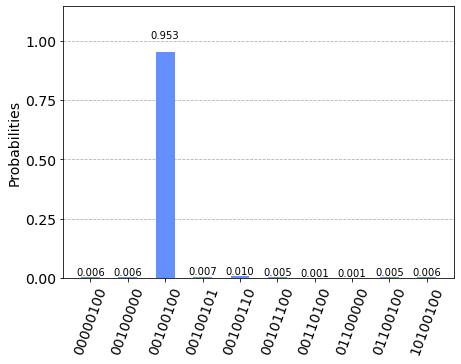

In [5]:
noise_model, depo_err_chan = get_noise(0.01)
a=4
b=9
qc = qft_multiplier(a,b)[0]
counts = execute(qc, Aer.get_backend('qasm_simulator'), 
                  noise_model=noise_model,
                  shots=1000).result().get_counts()
print('Most common value: ', int(max(counts, key=counts.get),2))
plot_histogram(counts)

The correct result is obtained on $95.3\%$ of the $1000$ shots run.

Let's try to increase the parameter $p$ and see the percentage of correct shots for the same values of $a$ and $b$.

QFT multiplier output: 36 
Correct answer: 36
Most common value:  36


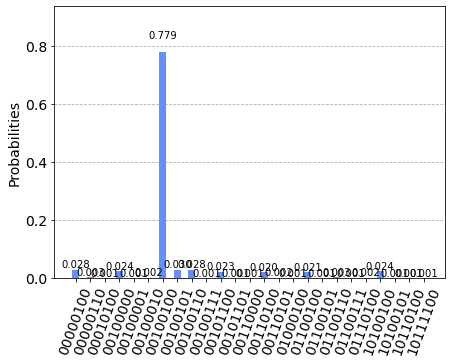

In [6]:
noise_model, depo_err_chan = get_noise(0.05)
a=4
b=9
qc = qft_multiplier(a,b)[0]
counts = execute(qc, Aer.get_backend('qasm_simulator'), 
                  noise_model=noise_model,
                  shots=1000).result().get_counts()
print('Most common value: ', int(max(counts, key=counts.get),2))
plot_histogram(counts)

As expected, we now get the correct result less frequently ($77.9\%$ of the time) and the number of different outcomes has increased.

To analyse the performance of this noisy version of the QFT multiplier systematically, we ran it for random pairs of $a$ and $b$ with $2,3,4,5$ bits. For each pair, the noisy circuit was run 1000 times and the proportion of correct shots saved. The table below shows how many random multiplications where performed as a function of the number of bits in the binary representation of $a$ and $b$

| Number of bits | Range for $a$ and $b$ | Number of random pairs multiplied | Number of all possible pairs | Percentage of all pairs explored |
|---|---|---|---|---|
|2| $$2^1 \leq a,b <2^2$$  |  3 | 3  | 100% |
|3| $$2^2 \leq a,b <2^3$$  |  10 | 10 | 100% |
|4| $$2^3\leq a,b <2^4$$ | 16  | 36 | 44% |
|5| $$2^4\leq a,b <2^5$$  |  32 | 136 | 24% |

As the table shows, the percentage of pairs explored decreases with the number of bits: this choice was dictated by the limited computing resources we had available. 

Figure 4 below shows boxplots for the proportion of corrects shots out of $1000$ as a function of the parameter $p$, for $a$ and $b$ with $2,3,4,5$ bits.

|<img src="Images/Noise_analysis_4in1.PNG" alt="drawing" width="800"/> |
|:--:|
| Figure 4: Boxplots of the proportion of correct shots out of 1000 for the QFT multiplier circuit with depolarizing error channel.

We see that for $p \leq 0.025$ the noisy circuit provides the correct answer at least $80%$ of the time for numbers up to $5$ digits. The performance of the noisy circuit is instead quite untrustworthy for values of $p\geq 0.1$. These observations are confirmed by Figure 5, where the average proportion of correct shots is plotted for different values of $p$ and different number of bits in $a$ and $b$:

|<img src="Images/Noise_analysis_allbits.png" alt="drawing" width="800"/> |
|:--:|
| Figure 5: Average proportion of correct shots out of 1000 for the QFT multiplier circuit with depolarizing error channel.

The plots in Figure 4 and Figure 5 were produced with the code in the file `Noise_analysis.py`.